In [11]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from IPython.display import clear_output
from kan import *
from app import cat_features, pca_pipeline, lag_features

device = 'cuda' if torch.cuda.is_available() else 'cpu'

![KAN](https://habrastorage.org/r/w1560/getpro/habr/upload_files/0df/035/99e/0df03599e984071a838e5b2957c662b8.png)

In [12]:
data = pd.read_csv('df_general.csv')
pd.set_option('display.max_columns', None) 
data[lag_features] = data[lag_features].fillna(999)
data.fillna(0, inplace=True)

In [13]:
epoch = 120
input_size = 20
output_size = 3

In [14]:
train = data[data['gameweek_compSeason_label'] != 2023]
test = data[data['gameweek_compSeason_label'] == 2023]

X_train = train.drop('team_1_hue', axis=1)
y_train = train['team_1_hue']

cat_cols = cat_features(X_train)
num_cols = list(set(X_train.columns.tolist()) - set(cat_cols))

X_test = test.drop('team_1_hue', axis=1)
y_test = test['team_1_hue']

X_train, pipeline = pca_pipeline(X_train, y_train, cat_cols, num_cols, n_components=input_size ,pca=True)
X_test = pipeline.transform(X_test)

In [15]:
X_train.shape, X_test.shape

((3192, 20), (180, 20))

In [16]:
dataset = {}

dataset['train_input'] = torch.tensor(X_train, dtype=torch.float32)
dataset['train_label'] = torch.tensor(list(y_train), dtype=torch.int16).long()
dataset['test_input'] = torch.tensor(X_test, dtype=torch.float32)
dataset['test_label'] = torch.tensor(list(y_test), dtype=torch.int16).long()

In [17]:
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([3192, 20]), torch.Size([3192]))

In [18]:
model = KAN(width=[input_size, input_size*3, input_size*2, input_size, output_size], grid=10, k=3, seed=0, device=device)

In [19]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input'].to(device)), dim=1) == dataset['train_label'].to(device)).float()) # .to(device)

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input'].to(device)), dim=1) == dataset['test_label'].to(device)).float()) # .to(device)

results = model.train(dataset, opt="LBFGS", steps=epoch, metrics=(train_acc, test_acc), device=device, loss_fn=torch.nn.CrossEntropyLoss())

train loss: 9.95e-01 | test loss: 9.68e-01 | reg: 1.19e+02 : 100%|█| 120/120 [1:56:22<00:00, 58.19s/


In [20]:
acc = accuracy_score(dataset['test_label'], torch.argmax(model(dataset['test_input'].to(device)), dim=1).cpu().detach().numpy())
f1 = f1_score(dataset['test_label'], torch.argmax(model(dataset['test_input'].to(device)), dim=1).cpu().detach().numpy(), average='weighted')
print(f'Accuracy: {acc:.3f}, F1: {f1:.3f}')

Accuracy: 0.572, F1: 0.526


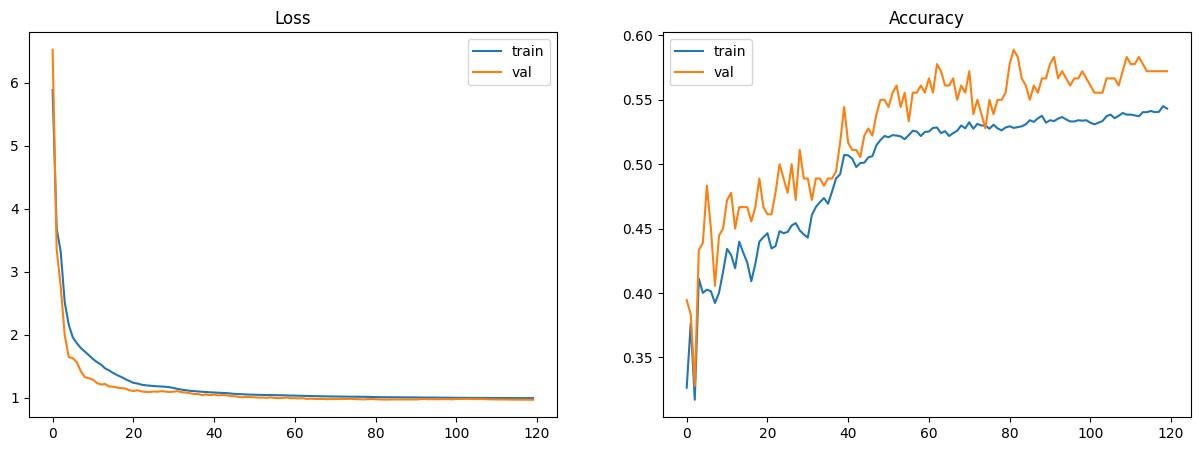

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(range(epoch), results['train_loss'], label='train')
axs[0].plot(range(epoch), results['test_loss'], label='val')
axs[0].title.set_text('Loss')
axs[0].legend()

axs[1].plot(range(epoch), results['train_acc'], label='train')
axs[1].plot(range(epoch), results['test_acc'], label='val')
axs[1].title.set_text('Accuracy')
axs[1].legend()

plt.show()